In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.kef as exp_kef
import experiments.efm as exp_efm

plt.rcParams["mathtext.fontset"] = "cm"

# load test results

#### galaxy

In [10]:
stats_res = pickle.load(open("../data/kef/kef_galaxy_level_stats_seed2024.pkl", "rb"))
eps_ls = list(stats_res.keys())
ol_means_ls = list(stats_res[eps_ls[0]].keys())

X_res = pickle.load(open("../data/kef/kef_galaxy_level_X_res_seed2024.pkl", "rb"))
est_params_res = pickle.load(open("../data/kef/kef_galaxy_level_est_params_res_seed2024.pkl", "rb"))
# tau_res = pickle.load(open("../data/kef/kef_galaxy_level_tau.pkl", "rb"))

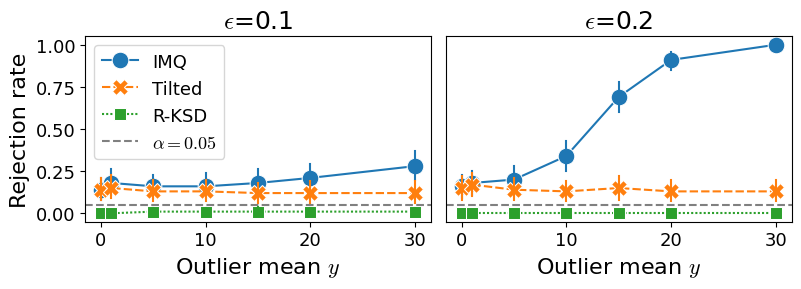

In [11]:
res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m, m_label in methods.items():
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

eps_ls_plot = [0.1, 0.2]
_, axes = plt.subplots(ncols=len(eps_ls_plot), figsize=(4*len(eps_ls_plot), 3))
for i, eps in enumerate(eps_ls_plot):
    ax = axes.flatten()[i] if len(eps_ls) > 1 else axes
    subplot_df = plot_df.loc[plot_df.eps == eps]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha = 0.05$")
    ax.legend([],[], frameon=False)
    ax.set_ylabel("Rejection rate", fontsize=16)
    ax.set_xlabel(r"Outlier mean $y$", fontsize=16)
    ax.set_title(rf"$\epsilon$={eps}", fontsize=18)
    ax.tick_params(axis="both", labelsize=13)
    if i > 0:
        ax.get_yaxis().set_visible(False)

axes[0].legend(fontsize=13, loc="upper left")
plt.tight_layout()
plt.savefig("../figs/robust/kef_level_rej.pdf")

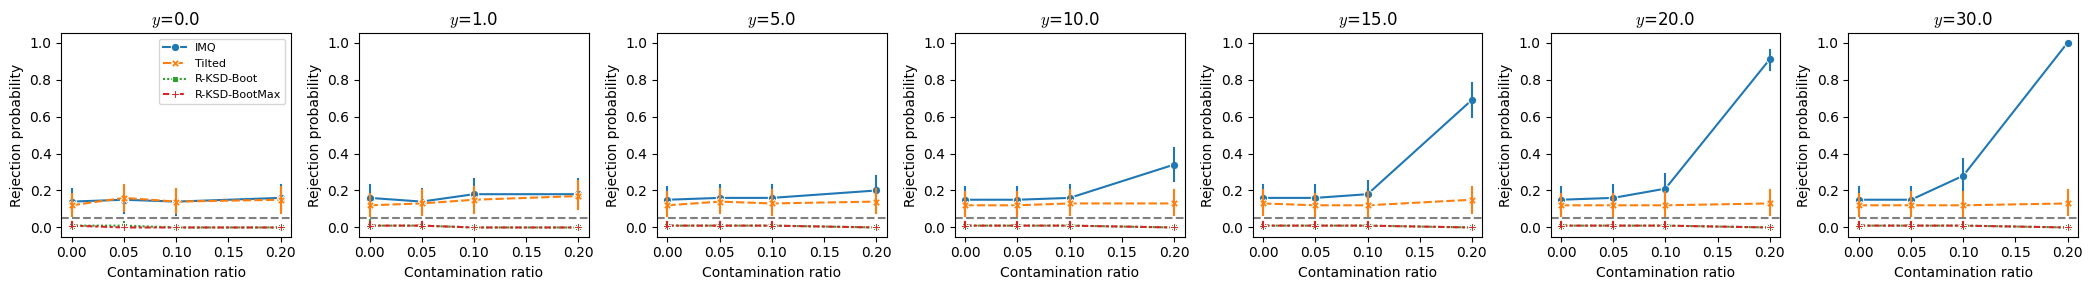

In [12]:
res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m, m_label in methods.items():
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

_, axes = plt.subplots(ncols=len(ol_means_ls), figsize=(3*len(ol_means_ls), 3))
for i, ol in enumerate(ol_means_ls):
    ax = axes.flatten()[i] if len(ol_means_ls) > 1 else axes
    subplot_df = plot_df.loc[plot_df.ol == ol]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")
    ax.set_title(rf"$y$={ol}")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.05, color="grey", linestyle="--")
    ax.legend([],[], frameon=False)
    ax.set_ylabel("Rejection probability")
    ax.set_xlabel("Contamination ratio")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend(fontsize=8)
# ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_rej.pdf")

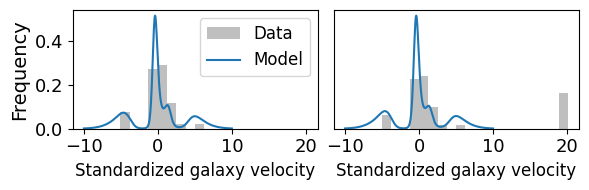

In [13]:
_, axes = plt.subplots(ncols=2, figsize=(3*2, 2))

# plot data
ol = 20.
eps_ls = [0., 0.2]
idx = 0
bins = np.histogram(np.hstack(
    (X_res[eps_ls[0]][ol][idx].reshape(-1), X_res[eps_ls[1]][ol][idx].reshape(-1))
), bins=20)[1]

for i, eps in enumerate(eps_ls):
    est_params = est_params_res[eps][ol][0]
    L = 25
    kef_l = jnp.sqrt(2)
    kef_p0_std = 3.
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)

    ax = axes[i]
    ax.hist(X_res[eps][ol][0].reshape(-1), bins, color="grey", alpha=0.5, density=True, label="Data")
    ax.plot(X_plot, approx_prob, label="Model")
    ax.set_xlabel("Standardized galaxy velocity", fontsize=12)
    ax.tick_params(axis="both", labelsize=13)
    if i == 0:
        ax.set_ylabel("Frequency", fontsize=14)
    if i > 0:
        ax.get_yaxis().set_visible(False)

axes[0].legend(fontsize=12)
plt.tight_layout()
# plt.savefig("../figs/robust/kef_level_data.pdf")

# Power 2

In [14]:
stats_res = pickle.load(open("../data/kef/kef_galaxy_power2_stats_seed2024.pkl", "rb"))
param_ls = list(stats_res.keys())

X_res = pickle.load(open("../data/kef/kef_galaxy_power2_X_res_seed2024.pkl", "rb"))
est_params_res = pickle.load(open("../data/kef/kef_galaxy_power2_est_params_res_seed2024.pkl", "rb"))
# tau_res = pickle.load(open("../data/kef/kef_galaxy_power2_tau.pkl", "rb"))

In [15]:
# # change theta
# eps0 = 0.2
# stats_res_new = copy.deepcopy(stats_res)
# for kk in param_ls:
#     theta_new = eps0 * tau_res[kk]**0.5
#     stats_res_new[kk] = exp_utils.change_theta(stats_res_new[kk], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)

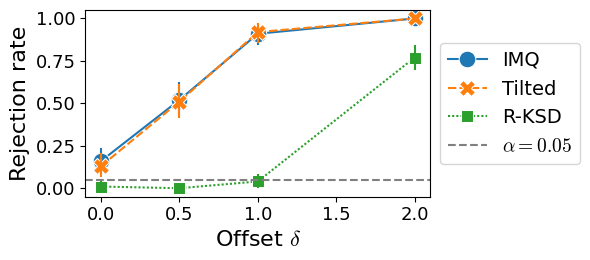

In [30]:
_, ax = plt.subplots(figsize=(6, 2.7))

res_plot = stats_res
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD"}

plot_df = {"key": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for kk in param_ls:
    rr = res_plot[kk]["tilted"]["nonsq_stat"]
    for m, m_label in methods.items():
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["key"] = plot_df["key"] + [kk] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[kk][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m_label] * len(rr)

plot_df = pd.DataFrame(plot_df)

_ = sns.lineplot(ax=ax, data=plot_df, x="key", y="rej", hue="method", style="method", markers=True, err_style="bars", markersize=12)
ax.set_ylim(-0.05, 1.05)
ax.axhline(0.05, color="grey", linestyle="--", label=r"$\alpha = 0.05$")
ax.set_ylabel("Rejection rate", fontsize=16)
ax.set_xlabel("Offset $\delta$", fontsize=16)
ax.tick_params(axis="both", labelsize=13)
lgd = ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
# ax.legend(fontsize=9)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2, fancybox=True, shadow=True)
plt.tight_layout()
plt.savefig("../figs/robust/kef_power_rej.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

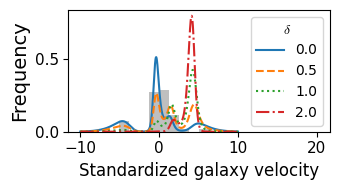

In [32]:
# 2. plot data
linestyles = ["solid", "dashed", "dotted", "dashdot"]

_, ax = plt.subplots(figsize=(3.5, 2))
# _, ax = plt.subplots(figsize=(6, 2.7))
for i, param in enumerate(param_ls):
    est_params = est_params_res[param][0]
    L = 25
    kef_l = jnp.sqrt(2)
    kef_p0_std = 3.
    
    trained_kef_model = exp_kef.KernelExpFamily(est_params, bw=kef_l, L=L, p0_loc=0., p0_scale=kef_p0_std)
    X_plot = np.reshape(np.linspace(-10., 10., 1001), (-1, 1))
    approx_prob = trained_kef_model.approx_prob(jax.random.PRNGKey(seed=56789), xs=X_plot, n_samples=2000)
    
    ax.plot(X_plot, approx_prob, label=f"{param}", linestyle=linestyles[i])
    
ax.hist(X_res[param_ls[0]][0].reshape(-1), bins=bins, color="grey", alpha=0.5, density=True)
ax.set_xlabel("Standardized galaxy velocity", fontsize=12)
ax.set_ylabel("Frequency", fontsize=14)
ax.tick_params(axis="both", labelsize=11)

lg = ax.legend(title=r"$\delta$")
# lg = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
# lg.set_title(r"$\delta$", prop={"size": 12})

plt.tight_layout()
plt.savefig("../figs/robust/kef_power_data.pdf", bbox_inches="tight")

#### synthetic

In [15]:
stats_res = pickle.load(open("../data/kef/kef_stats_seed2024.pkl", "rb"))
eps_ls = list(stats_res.keys())
ol_means_ls = list(stats_res[eps_ls[0]].keys())

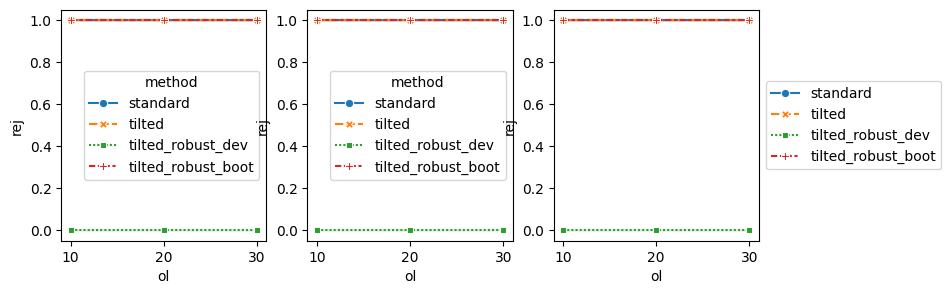

In [19]:
_, axes = plt.subplots(ncols=len(eps_ls), figsize=(3*len(eps_ls), 3))

res_plot = stats_res
method_list = ["standard", "tilted", "tilted_robust_dev", "tilted_robust_boot"]

plot_df = {"eps": [], "ol": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    for ol in ol_means_ls:
        rr = res_plot[eps][ol]["tilted"]["nonsq_stat"]
        for m in method_list:
            plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
            plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
            plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
            plot_df["ol"] = plot_df["ol"] + [ol] * len(rr)
            
            plot_df["rej"] = plot_df["rej"] + res_plot[eps][ol][m]["rej"]
            plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

for i, ax in enumerate(axes.flatten()):
    subplot_df = plot_df.loc[plot_df.eps == eps_ls[i]]
    
    _ = sns.lineplot(ax=ax, data=subplot_df, x="ol", y="rej", hue="method", style="method", markers=True)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

#### visualise weighting function

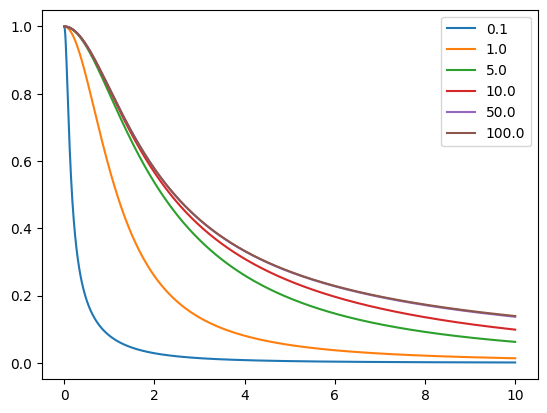

In [196]:
# weighting function
x_kernel = np.linspace(-0, 10., 1001).reshape((-1, 1))

for a in [0.1, 1., 5., 10., 50., 100.]:
    poly_weight_fn = kernels.PolyWeightFunction(a=a)
    kernel0 = kernels.IMQ(sigma_sq=2*1.**2, X=x_kernel, Y=x_kernel)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=poly_weight_fn)
    
    kk_mat = kernel(x_kernel, x_kernel)
    
    _ = plt.plot(x_kernel[:, 0], kk_mat[0], label=a)

_ = plt.legend()